In [1]:
import numpy as np
import pandas as pd
import math
from numpy.linalg import inv

In [4]:
df=pd.read_csv('big_data.csv',sep=';')
df.head()

T1     T2     T3      T4      T5      T6      Temp        Vb          X  \
0   0  323.0  726.0  1181.0  1030.0  1492.0  29.78508  773.9938 -10.464600   
1   0  321.0  866.0  1113.0  1168.0  1421.0  29.78508  778.8162  -5.733915   
2   0  317.0  165.0  1328.0   469.0  1636.0  30.27336  788.6436 -27.230460   
3   0  313.0  434.0  1347.0   733.0  1650.0  31.24992  798.7220 -20.184890   
4   0  324.0  760.0   940.0  1065.0  1253.0  31.24992  771.6050  -4.733973   

          Y  
0  34.22198  
1  33.54162  
2  38.23891  
3  31.24276  
4  45.05524

In [7]:
df.T2/=1000
df.T3/=1000
df.T4/=1000
df.T5/=1000
df.T6/=1000
df['Vs']=20.02*(273+df.Temp)**0.5/1000
df.head()

T1     T2     T3     T4     T5     T6      Temp        Vb          X  \
0   0  0.323  0.726  1.181  1.030  1.492  29.78508  773.9938 -10.464600   
1   0  0.321  0.866  1.113  1.168  1.421  29.78508  778.8162  -5.733915   
2   0  0.317  0.165  1.328  0.469  1.636  30.27336  788.6436 -27.230460   
3   0  0.313  0.434  1.347  0.733  1.650  31.24992  798.7220 -20.184890   
4   0  0.324  0.760  0.940  1.065  1.253  31.24992  771.6050  -4.733973   

          Y        Vs  
0  34.22198  0.348362  
1  33.54162  0.348362  
2  38.23891  0.348643  
3  31.24276  0.349204  
4  45.05524  0.349204

# ITERATIVE ALGORITHM

In [8]:
def fun(X,c):
    x,h,V,alpha,t_offset = list(X)
    #T1,T2,T3,T4,T5,T6 x and y co-ordinate
    x0 = [0.0,0.0,0.63,-0.63,0.63]
    y0 = [0.0,0.25,0.0,0.25,0.25]
    T=[]
    for j in range(len(x0)):
        x_k,y_k = x0[j],y0[j]
        t_i = t_offset -((1/V)*((x-x_k)*math.sin(alpha)-y_k*math.cos(alpha)))\
            +((((x-x_k)*math.cos(alpha)+y_k*math.sin(alpha))**2+h**2)**0.5)*((1/c**2)-(1/V**2))**0.5
        T.append(t_i)
    return np.asarray(T,dtype='float')

In [9]:
def derivative_matrix(X,c):
    x,h,V,alpha,t_offset = list(X)
    #T1,T2,T3,T4,T5,T6 x and y co-ordinate
    x0 = [0.0,0.0,0.63,-0.63,0.63]
    y0 = [0.0,0.25,0.0,0.25,0.25]
    derivate=[]
    for j in range(len(x0)):
        x_k,y_k = x0[j],y0[j]
        Q = ((((x-x_k)*math.cos(alpha)+y_k*math.sin(alpha))**2+h**2)**0.5)
        dt_dx = -(math.sin(alpha)/V) + ((1/Q)*((1/c**2)-(1/V**2))**0.5)\
            *((x-x_k)*math.cos(alpha)+y_k*math.sin(alpha))*math.cos(alpha)
        dt_dh = (h/Q)*((1/c**2)-(1/V**2))**0.5
        dt_dV = (1/V**2)*((x-x_k)*math.sin(alpha)-y_k*math.cos(alpha))+(Q/(V**3*((1/c**2)-(1/V**2))**0.5))
        #dt_dc = -(Q/(c**3*((1/c**2)-(1/V**2))**0.5))
        dt_dalpha = -((x-x_k)*math.cos(alpha)+y_k*math.sin(alpha))\
                *((1/V)+(1/Q)*(((1/c**2)-(1/V**2))**0.5)*((x-x_k)*math.sin(alpha)-y_k*math.cos(alpha)))
        dt_dt_offset = 1
        derivate.append([dt_dx,dt_dh,dt_dV,dt_dalpha,dt_dt_offset])
    return np.asarray(derivate,dtype='float')

In [110]:
def iterative_nonliner_solver(i):
    x_old_log=[]
    x_new_log=[]
    for j in range(100):
        print("\n#########################################    "+str(j)+"   *******************************************\n")
        if j==0:
            #x,h,V,c,alpha,t_offset = []
            X_guess = np.array([0.01,0.2,0.6,0.0,0.0],dtype='float')
            X_old = X_guess
            #print(f'X_old:{X_old}')
        #print(f'X_old:{X_old}')
        x_old_log.append(X_old)
        #i=0
        M_calculated=fun(X_old,df.Vs[i])
        M_calculated=M_calculated.reshape(1,5)
        #print(f'M_calculated:{M_calculated}')
        M_measured = np.asarray([df.T1[i],df.T2[i],df.T4[i],df.T5[i],df.T6[i]],dtype='float')
        M_measured =M_measured.reshape(1,5)
        #print("M_measured:",M_measured)
        H =derivative_matrix(X_old,df.Vs[i])
        #print(np.matmul(np.matmul(inv(np.matmul(H.T,H)),H.T),(M_measured.T-M_calculated.T)))
        #print(inv(np.matmul(H.T,H)))
        try:
            #print(inv(np.matmul(H.T,H)))
            X_new = X_old.reshape(1,5).T+np.matmul(np.matmul(inv(np.matmul(H.T,H)),H.T),(M_measured.T-M_calculated.T))
            #X_new=np.array([X_new[0][0],X_new[1][0],X_new[2][0],X_new[3][0],X_new[4][0],X_new[5][0]])
            X_old= X_new.reshape(1,5)[0]
            #print("X_new:",X_old)
            x_new_log.append(X_old)
            #print("Residual vector after each iteration:",M_measured-M_calculated)
            if j>=1:
                if(np.all(np.isclose(x_old_log[j-1],x_old_log[j]))):
                    return X_old,H
                    break

                #if(np.array_equal(x_old_log[j-1],x_old_log[j])):
                    #break
            #print("\n#########################################    "+str(j)+"   *******************************************\n")
        except np.linalg.LinAlgError:
            #print(x_old_log)
            x_new=[-x_new_log[0][0]/100,x_new_log[0][1]/100,x_new_log[0][2],x_new_log[0][3]/10,x_new_log[0][4]]
            return x_new,H
            break

In [111]:
X_old,_=iterative_nonliner_solver(24)
print(X_old)


#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************

[-0.04510873443057505, 0.006101166363448467, -0.906509988970975, 2.020600816324959, -1.0101128352649857]


In [112]:
with open("big_data_result_compare.txt","w+")as f:
    f.write("their_x,our_x,their_y,our_y,their_v,our_v,alpha\n")
    for i in range(0,3903):
        try:
            X_old,_=iterative_nonliner_solver(i)
            result_str=str(df.X[i])+","+str(X_old[0]*100)+","+str(df.Y[i])+","+str(X_old[1]*100)+","+str(df.Vb[i])+","+str(X_old[2]*1000)+","+str(X_old[3])+"\n"
            print(f"i:{i},X:{X_old}")
            f.write(result_str)
        except:
            print(i)


#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************

i:0,X:[-0.09921675  0.33455465  0.76140407  0.02968177 -0.89454841]

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   ***************************

i:65,X:[-0.15958015  0.68639336  0.74780254  0.03007818 -1.76915937]

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************

i:66,X:[-0.15050302  0.71468468  0.76751169  0.02082393 -1.84422432]

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


######



#########################################    5   *******************************************

i:126,X:[-0.28426659  0.60438697  0.76128529  0.03839694 -1.69826496]

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************

i:127,X:[-0.04101568  0.43524451  0.77015663  0.02732992 -1.10833918]

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


###



#########################################    3   *******************************************


#########################################    4   *******************************************

i:188,X:[-0.12083004  0.49925941  0.75598196  0.03154971 -1.30040568]

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************

i:189,X:[-0.11445335  0.74708274  0.77137185  0.01135859 -1.91801491]

#########################################    0   *******************************************


###

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in double_scalars
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in double_scalars
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_lau



#########################################    79   *******************************************


#########################################    80   *******************************************


#########################################    81   *******************************************


#########################################    82   *******************************************


#########################################    83   *******************************************


#########################################    84   *******************************************


#########################################    85   *******************************************


#########################################    86   *******************************************


#########################################    87   *******************************************


#########################################    88   *******************************************


######################################

i:288,X:[ 0.09654762  0.81197249  0.77135594  0.02624491 -2.04739862]

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************

i:289,X:[ 0.28959225  0.62346701  0.7709577   0.01417048 -1.71844331]

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


####



#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************

i:335,X:[ 0.055053    0.52158195  0.78457262  0.02059828 -1.3184602 ]

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************

i:336,X:[-0.06887116  0.60457888  0.77738182  0.02218978 -1.52963423]

###



#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************

i:406,X:[ 0.05546293  0.52706223  0.75381771  0.02054668 -1.34210521]

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************

i:407,X:[-0.04277105  0.76124879  0.76507971  0.02067865 -1.94188292]

###



#########################################    4   *******************************************


#########################################    5   *******************************************

i:467,X:[ 0.16561017  0.22624631  0.81564888  0.02519631 -0.70920792]

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************

i:468,X:[ 0.19531464  0.21706867  0.79937472  0.01711847 -0.73623357]

#########################################    0   *******************************************


###



#########################################    77   *******************************************


#########################################    78   *******************************************


#########################################    79   *******************************************


#########################################    80   *******************************************


#########################################    81   *******************************************


#########################################    82   *******************************************


#########################################    83   *******************************************


#########################################    84   *******************************************


#########################################    85   *******************************************


#########################################    86   *******************************************


######################################



#########################################    4   *******************************************

i:577,X:[-0.02612667444842802, 0.003205440033550883, -3.9291619289730275, 1.1505422581982194, 0.9490106436233912]

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************

i:578,X:[-0.01478826  0.38495021  0.75788664  0.03790053 -0.97983571]

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *****


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************

i:641,X:[ 0.03467182  0.51452577  0.92189266  0.03988488 -1.36907072]

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************

i:642,X:[-0.05644417  0.37573789  0.90052084  0.04886147 -1.00880453]

####



#########################################    4   *******************************************


#########################################    5   *******************************************

i:693,X:[-0.03048131  0.63642301  0.772782    0.01633636 -1.62015684]

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************

i:694,X:[ 0.11111649  0.56863013  0.77155948  0.01633008 -1.46971558]

#########################################    0   *******************************************


###

i:753,X:[ 0.11008346  0.49015653  0.77233134  0.01666478 -1.26797055]

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************

i:754,X:[-0.02125365  0.49471037  0.76553629  0.02093454 -1.24979903]

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


####



#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************

i:810,X:[-0.04321806  0.7919403   0.75789469  0.02389764 -2.00895076]

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************

i:811,X:[-0.21911744  0.82506268  0.74866007  0.0239987  -2.16052709]

###


#########################################    19   *******************************************


#########################################    20   *******************************************


#########################################    21   *******************************************


#########################################    22   *******************************************


#########################################    23   *******************************************


#########################################    24   *******************************************


#########################################    25   *******************************************


#########################################    26   *******************************************


#########################################    27   *******************************************


#########################################    28   *******************************************


#######################################



#########################################    13   *******************************************


#########################################    14   *******************************************


#########################################    15   *******************************************


#########################################    16   *******************************************


#########################################    17   *******************************************


#########################################    18   *******************************************


#########################################    19   *******************************************


#########################################    20   *******************************************


#########################################    21   *******************************************


#########################################    22   *******************************************


######################################



#########################################    51   *******************************************


#########################################    52   *******************************************


#########################################    53   *******************************************


#########################################    54   *******************************************


#########################################    55   *******************************************


#########################################    56   *******************************************


#########################################    57   *******************************************


#########################################    58   *******************************************


#########################################    59   *******************************************


#########################################    60   *******************************************


######################################



#########################################    97   *******************************************


#########################################    98   *******************************************


#########################################    99   *******************************************

923

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************

i:924,X:[-0.02912906302489863, -0.001953445828881392, -6.9000962390749425, 1.2291557728323728, 3.3588095536114153]

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************

i:925,X:[-0.0660130515

i:975,X:[ 0.04307568  0.81217318  0.75776513  0.0024987  -2.03782223]

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************

i:976,X:[ 0.08747827  0.60386413  0.80064187  0.019358   -1.54724243]

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


####


#########################################    18   *******************************************


#########################################    19   *******************************************


#########################################    20   *******************************************


#########################################    21   *******************************************


#########################################    22   *******************************************


#########################################    23   *******************************************


#########################################    24   *******************************************


#########################################    25   *******************************************


#########################################    26   *******************************************


#########################################    27   *******************************************


#######################################



#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************

i:1106,X:[ 0.09314472  0.72316261  0.79005209  0.01959418 -1.84489415]

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   ***********************



#########################################    4   *******************************************


#########################################    5   *******************************************

i:1169,X:[ 0.18934111  0.70171543  0.76505172  0.02598515 -1.82683298]

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************

i:1170,X:[ 0.19209851  0.84132584  0.77134812  0.02079546 -2.17631638]

#########################################    0   *******************************************


#

i:1253,X:[ 0.24099324  1.33573835  0.77527501  0.01366026 -3.47297966]

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************


#########################################    6   *******************************************


#########################################    7   *******************************************

i:1254,X:[ 0.06088099  1.73473495  0.7728496   0.02702595 -4.44122501]

#########################################    0   *******************************************


##



#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************

i:1326,X:[-0.1360164   0.4090747   0.76356052  0.02231387 -1.08534722]

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************

i:1327,X:[ 0.0448702   0.47051756  0.77633658  0.01628547 -1.18996695]

#########################################    0   *******************************************


#



#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************

i:1397,X:[-0.25919397  0.75917331  0.76574616  0.00725219 -2.02236375]

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************

i:1398,X:[-0.19554589  0.77915863  0.74728242  0.02303981 -2.01508007]

#



#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************

i:1470,X:[-0.27420102  0.77310368  0.76002517  0.01854553 -2.07621808]

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************

i:1471,X:[-0.19209275  0.82835571  0.76588189  0.00991184 -2.15014069]

#


i:1546,X:[ 0.1992821   0.91876081  0.76605164  0.0125483  -2.35008773]

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************

i:1547,X:[-0.06499608  0.88140899  0.76258995  0.01755503 -2.21112629]

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#

i:1626,X:[ 0.03827103  0.26885739  0.76239176  0.01192502 -0.68930115]

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************

i:1627,X:[-0.14079901  0.66251697  0.77038516  0.01138082 -1.72747551]

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


##


#########################################    3   *******************************************


#########################################    4   *******************************************

i:1700,X:[ 0.05114574  0.50590177  0.76908317  0.01490235 -1.27448123]

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************

i:1701,X:[-0.07324914  0.53695416  0.77975274  0.0072123  -1.36500308]

#########################################    0   *******************************************


#########################################    1   *******************************************


##



#########################################    4   *******************************************


#########################################    5   *******************************************


#########################################    6   *******************************************

i:1772,X:[-1.45703201e-01  1.31155615e+00  7.73993808e-01  3.45471367e-16
 -3.32892468e+00]

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************

i:1773,X:[-1.16033704e-01  4.83000410e-01  7.59878330e-01  2.63286801e-07
 -1.24567184e+00]

#########################################    0   *****


#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************

i:1843,X:[-0.09544172  0.53689896  0.62024119 -0.01938686 -1.25640904]

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   ************************

i:1901,X:[ 0.27236271  0.35154236  0.81202122  0.02578591 -1.13529384]

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************

i:1902,X:[ 0.07951659  0.50528657  0.79436851  0.03310258 -1.30581361]

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


##


#########################################    5   *******************************************

i:1959,X:[ 0.11316838  0.49977309  0.8081918   0.03316716 -1.30449447]

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************

i:1960,X:[ 0.13973331  0.44371978  0.8278979   0.03125334 -1.18973409]

#########################################    0   *******************************************


#########################################    1   *******************************************


##



#########################################    3   *******************************************

i:2030,X:[-0.02584122505158835, 0.005482027781645461, -2.152147844279229, 1.1179933531202053, -0.26123961288467923]

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************

i:2031,X:[-0.14269458010274452, -0.05986572795611331, -41.43868352671696, 6.07147648172629, 30.07419893623014]

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************

i:2032,X:[-0


#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************

i:2081,X:[ 0.11575241  0.49307462  0.82772653  0.0410088  -1.28654649]

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   ************************

i:2152,X:[-0.20962878  0.61351229  0.77561855  0.05432616 -1.66723013]

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************

i:2153,X:[-0.24184736  0.50568252  0.77489419  0.0671968  -1.44900142]

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


##


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************

i:2226,X:[ 0.01268394  0.61988113  0.80493283  0.03454023 -1.57278379]

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************

i:2227,X:[ 0.03666116  0.54049342  0.80814718  0.03876175 -1.37424235]

##



#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************

i:2301,X:[ 0.29392767  0.28116732  0.82956535  0.02304805 -1.03405971]

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************

i:2302,X:[ 0.31229214  0.27534645  0.83447019  0.02588772 -1.05843986]

#


#########################################    4   *******************************************


#########################################    5   *******************************************

i:2373,X:[-0.14849898  0.77577966  0.79086103  0.06622515 -2.00797476]

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************

i:2374,X:[-0.06687075  0.77737568  0.78680276  0.06483965 -1.9743237 ]

#########################################    0   *******************************************


##


i:2445,X:[-0.01155465  0.58319558  0.86538033 -0.00868158 -1.49539776]

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************

i:2446,X:[-0.16485038  0.5546717   0.85460727  0.00292027 -1.48030207]

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#


#########################################    5   *******************************************


#########################################    6   *******************************************

i:2512,X:[-0.04486182  1.10323335  0.84244973 -0.00970764 -2.83851347]

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************


#########################################    6   *******************************************

i:2513,X:[ 0.01139768  1.22153529  0.84718229 -0.01349193 -3.14491494]

##



#########################################    5   *******************************************

i:2581,X:[-0.0259596   0.78063774  0.84776772 -0.00506777 -2.02237488]

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************

i:2582,X:[-0.0166653   0.67912682  0.83343538 -0.00233206 -1.75269666]

#########################################    0   *******************************************


#########################################    1   *******************************************


#


#########################################    17   *******************************************


#########################################    18   *******************************************


#########################################    19   *******************************************


#########################################    20   *******************************************


#########################################    21   *******************************************


#########################################    22   *******************************************


#########################################    23   *******************************************


#########################################    24   *******************************************


#########################################    25   *******************************************


#########################################    26   *******************************************


#######################################



#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************

i:2713,X:[-0.04203644  0.43309949  0.85223992 -0.01052503 -1.11470555]

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   ***********************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************

i:2783,X:[ 0.24562285  0.44995861  0.81658962  0.00273775 -1.32618017]

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************

i:2784,X:[ 0.27853492  0.57993557  0.82483654  0.00330468 -1.63605227]

##



#########################################    5   *******************************************

i:2854,X:[ 0.14194407  0.66589087  0.82307379  0.00193811 -1.756621  ]

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************


#########################################    6   *******************************************

i:2855,X:[ 2.15349274e-01  9.37709806e-01  8.22368421e-01 -2.36255390e-16
 -2.48230403e+00]

#########################################    0   **************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************

i:2927,X:[-0.17799132  0.22835727  0.79191813  0.0220229  -0.74903482]

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   ************************


2984

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************


#########################################    6   *******************************************


#########################################    7   *******************************************


#########################################    8   *******************************************


#########################################    9   *******************************************


#########################################  


#########################################    8   *******************************************


#########################################    9   *******************************************


#########################################    10   *******************************************


#########################################    11   *******************************************


#########################################    12   *******************************************


#########################################    13   *******************************************


#########################################    14   *******************************************


#########################################    15   *******************************************


#########################################    16   *******************************************


#########################################    17   *******************************************


#########################################



#########################################    32   *******************************************


#########################################    33   *******************************************


#########################################    34   *******************************************


#########################################    35   *******************************************


#########################################    36   *******************************************


#########################################    37   *******************************************


#########################################    38   *******************************************


#########################################    39   *******************************************


#########################################    40   *******************************************


#########################################    41   *******************************************


######################################


#########################################    10   *******************************************


#########################################    11   *******************************************


#########################################    12   *******************************************


#########################################    13   *******************************************


#########################################    14   *******************************************


#########################################    15   *******************************************


#########################################    16   *******************************************


#########################################    17   *******************************************


#########################################    18   *******************************************


#########################################    19   *******************************************


#######################################



#########################################    27   *******************************************


#########################################    28   *******************************************


#########################################    29   *******************************************


#########################################    30   *******************************************


#########################################    31   *******************************************


#########################################    32   *******************************************


#########################################    33   *******************************************


#########################################    34   *******************************************


#########################################    35   *******************************************


#########################################    36   *******************************************


######################################


#########################################    10   *******************************************


#########################################    11   *******************************************


#########################################    12   *******************************************


#########################################    13   *******************************************


#########################################    14   *******************************************


#########################################    15   *******************************************

i:3075,X:[0.0002001240298981733, 0.004815141339872825, 0.7630536081238373, -0.07735739909001307, -1.1928230306957914]

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


####################



#########################################    47   *******************************************


#########################################    48   *******************************************


#########################################    49   *******************************************


#########################################    50   *******************************************


#########################################    51   *******************************************


#########################################    52   *******************************************


#########################################    53   *******************************************


#########################################    54   *******************************************


#########################################    55   *******************************************


#########################################    56   *******************************************


######################################


#########################################    27   *******************************************


#########################################    28   *******************************************


#########################################    29   *******************************************


#########################################    30   *******************************************


#########################################    31   *******************************************


#########################################    32   *******************************************


#########################################    33   *******************************************


#########################################    34   *******************************************


#########################################    35   *******************************************


#########################################    36   *******************************************


#######################################



#########################################    37   *******************************************


#########################################    38   *******************************************


#########################################    39   *******************************************


#########################################    40   *******************************************


#########################################    41   *******************************************


#########################################    42   *******************************************


#########################################    43   *******************************************


#########################################    44   *******************************************


#########################################    45   *******************************************


#########################################    46   *******************************************


######################################


#########################################    4   *******************************************


#########################################    5   *******************************************


#########################################    6   *******************************************


#########################################    7   *******************************************

i:3118,X:[ 0.01260706  0.32604758  1.19413414  0.53084888 -0.88645978]

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   ************************



#########################################    27   *******************************************


#########################################    28   *******************************************


#########################################    29   *******************************************


#########################################    30   *******************************************


#########################################    31   *******************************************


#########################################    32   *******************************************


#########################################    33   *******************************************


#########################################    34   *******************************************


#########################################    35   *******************************************


#########################################    36   *******************************************


######################################


#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************

i:3160,X:[0.0025586481945050676, 0.00518881322331559, 0.8091960063605301, -0.12830472176902835, -1.2843744571942723]

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


###########################



#########################################    93   *******************************************


#########################################    94   *******************************************


#########################################    95   *******************************************


#########################################    96   *******************************************


#########################################    97   *******************************************


#########################################    98   *******************************************


#########################################    99   *******************************************

3202

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


####################################


#########################################    87   *******************************************


#########################################    88   *******************************************


#########################################    89   *******************************************


#########################################    90   *******************************************


#########################################    91   *******************************************


#########################################    92   *******************************************


#########################################    93   *******************************************


#########################################    94   *******************************************


#########################################    95   *******************************************


#########################################    96   *******************************************


#######################################



#########################################    82   *******************************************


#########################################    83   *******************************************


#########################################    84   *******************************************


#########################################    85   *******************************************


#########################################    86   *******************************************


#########################################    87   *******************************************


#########################################    88   *******************************************


#########################################    89   *******************************************


#########################################    90   *******************************************


#########################################    91   *******************************************


######################################


#########################################    76   *******************************************


#########################################    77   *******************************************


#########################################    78   *******************************************


#########################################    79   *******************************************


#########################################    80   *******************************************


#########################################    81   *******************************************


#########################################    82   *******************************************


#########################################    83   *******************************************


#########################################    84   *******************************************


#########################################    85   *******************************************


#######################################



#########################################    71   *******************************************


#########################################    72   *******************************************


#########################################    73   *******************************************


#########################################    74   *******************************************


#########################################    75   *******************************************


#########################################    76   *******************************************


#########################################    77   *******************************************


#########################################    78   *******************************************


#########################################    79   *******************************************


#########################################    80   *******************************************


######################################


#########################################    65   *******************************************


#########################################    66   *******************************************


#########################################    67   *******************************************


#########################################    68   *******************************************


#########################################    69   *******************************************


#########################################    70   *******************************************


#########################################    71   *******************************************


#########################################    72   *******************************************


#########################################    73   *******************************************


#########################################    74   *******************************************


#######################################



#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************

i:3268,X:[-0.18033537  0.55576706  0.77303235 -0.00305819 -1.48159373]

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************

i:3269,X:[-1.82807953e-01  5.25773884e-01  7.73993808e-01  7.02473423e-16
 -1.41263101e+00]

#########################################    0   **************************


#########################################    4   *******************************************

i:3341,X:[-0.12590079  0.37316369  0.78344179  0.00546569 -0.99748345]

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************

i:3342,X:[ 0.12022282  0.82859904  0.76432353 -0.01192808 -2.10694305]

#########################################    0   *******************************************


#########################################    1   *******************************************


##



#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************


#########################################    6   *******************************************

i:3415,X:[ 0.23425032  1.21822514  0.76941372 -0.01589537 -3.14184366]

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   ***********************


#########################################    94   *******************************************


#########################################    95   *******************************************


#########################################    96   *******************************************


#########################################    97   *******************************************


#########################################    98   *******************************************


#########################################    99   *******************************************

3475

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


######################################



#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************

i:3548,X:[-0.01150701  0.36957122  0.79627339 -0.00190424 -0.93035121]

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   ***********************


#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************

i:3621,X:[ 0.06407015  0.65847871  0.78702402 -0.01060258 -1.67041058]

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   ************************



#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************

i:3691,X:[ 0.11095757  0.75755519  0.70688762 -0.01859566 -1.86187341]

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************

i:3692,X:[-0.259729    0.51179072  0.62642118  0.00413599 -1.33962457]

#


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************

i:3766,X:[ 0.14907926  0.43637201  0.7567868  -0.03580253 -1.17613321]

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************

i:3767,X:[ 0.14907926  0.43637201  0.7567868  -0.03580253 -1.17613321]

#########################################    0   *******************************************


##


i:3839,X:[ 0.02658717  0.52348021  0.91268522  0.03159648 -1.389789  ]

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************

i:3840,X:[-0.06453181  0.37883815  0.89186869  0.03989231 -1.01837751]

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#


#########################################    5   *******************************************


#########################################    6   *******************************************

i:3883,X:[ 0.02321406  1.30239431  0.6968187   0.03363806 -3.16244966]

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************


#########################################    6   *******************************************

i:3884,X:[ 0.09995156  1.03468424  0.765334    0.00578244 -2.60328735]

##

In [113]:
df_m=pd.read_csv('big_data_result_compare.txt')
df_m.head()

their_x      our_x   their_y      our_y   their_v       our_v     alpha
0 -10.464600  -9.921675  34.22198  33.455465  773.9938  761.404066  0.029682
1  -5.733915  -5.272370  33.54162  32.648416  778.8162  772.317647  0.026999
2 -27.230460 -26.749705  38.23891  38.077127  788.6436  753.576153  0.040179
3 -20.184890 -19.772383  31.24276  30.935963  798.7220  766.330131  0.038551
4  -4.733973  -4.168366  45.05524  43.944952  771.6050  768.332337  0.023071

In [135]:
i, j = 100, 125

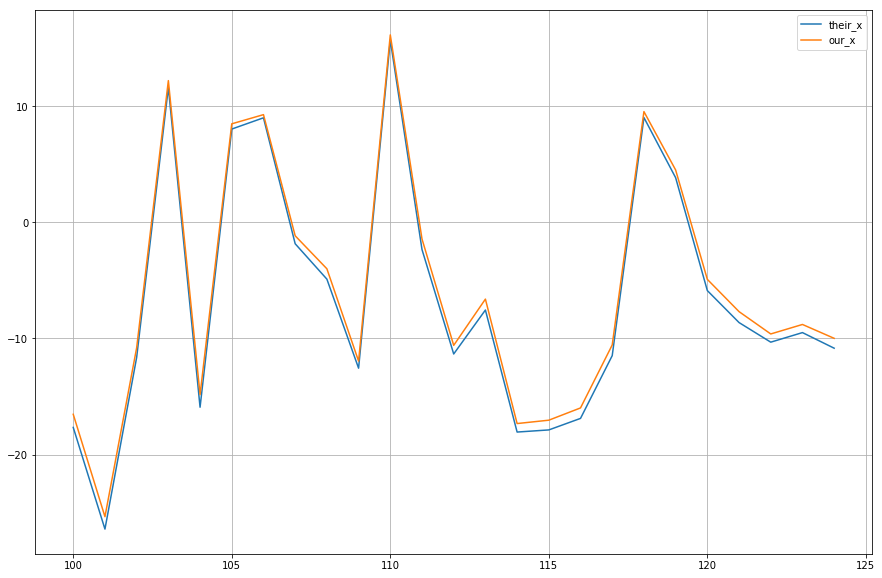

In [185]:
df_m[i:j].plot(y=['their_x','our_x'],figsize=(15,10),grid=True,kind='line')

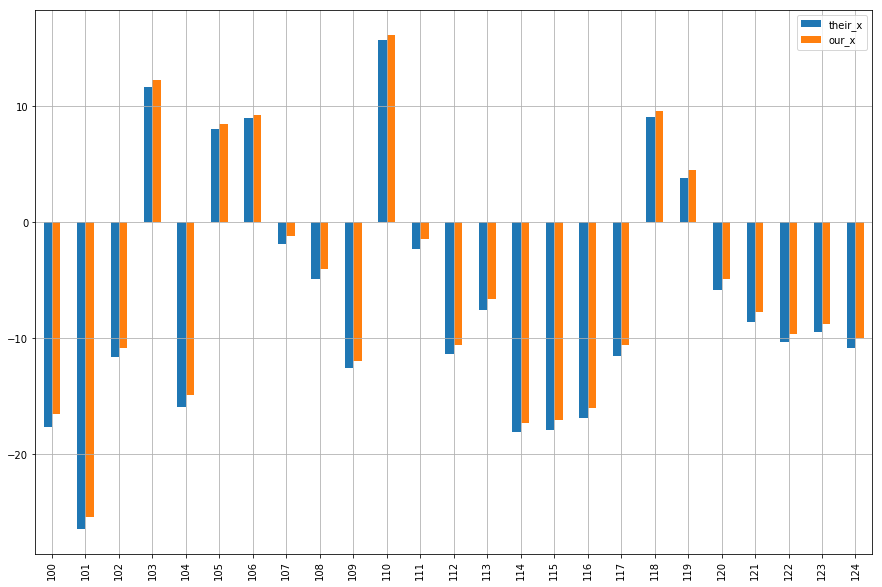

In [178]:
df_m[i:j].plot(y=['their_x','our_x'],figsize=(15,10),grid=True,kind='bar')

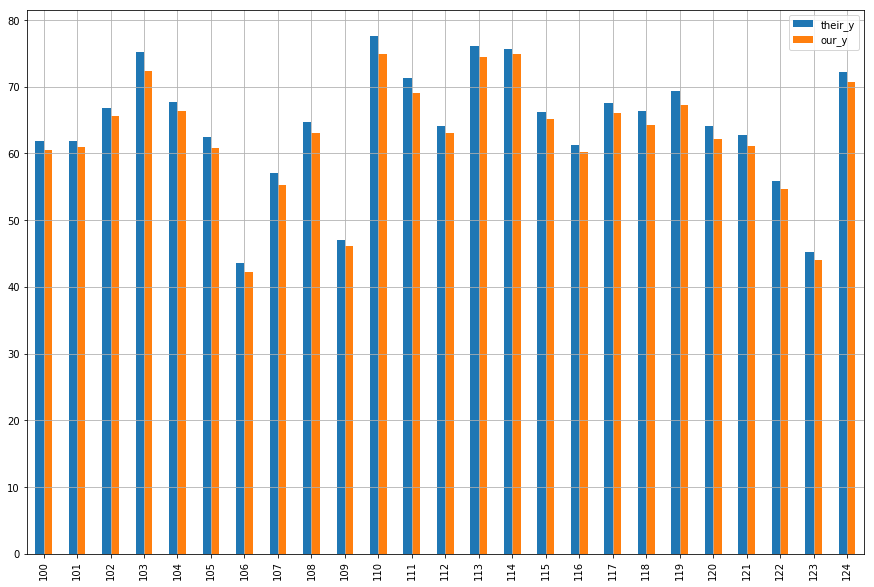

In [154]:
df_m[i:j].plot(y=['their_y','our_y'],figsize=(15,10),grid=True,kind='bar')

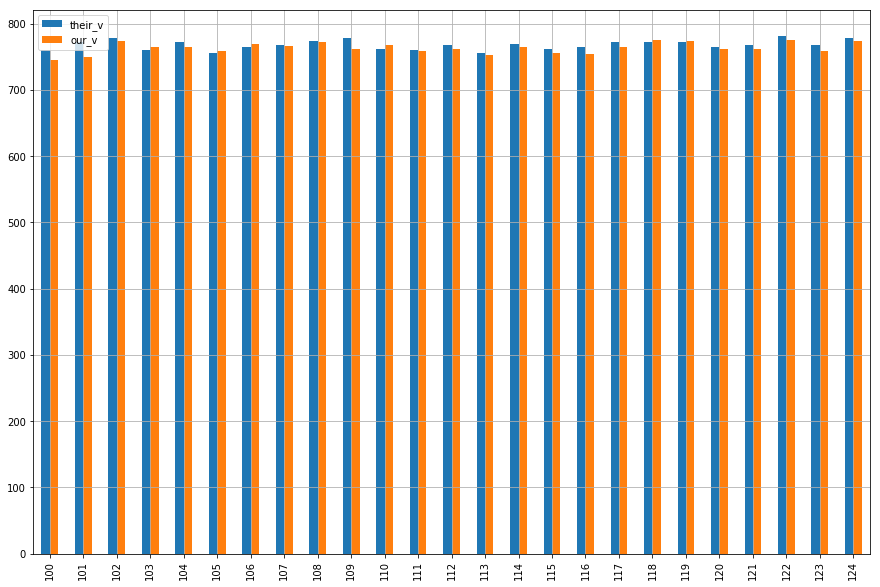

In [187]:
df_m[i:j].plot(y=['their_v','our_v'],figsize=(15,10),grid=True,kind='bar')

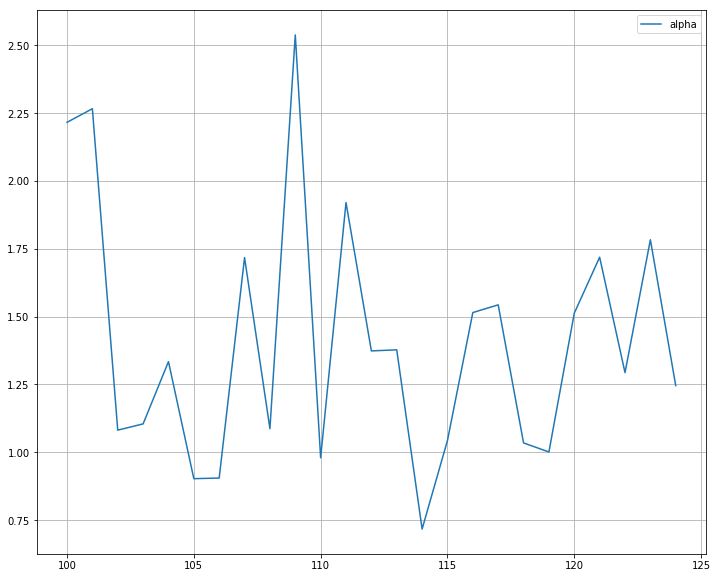

In [145]:
# df_m[i:j].plot(y=['alpha'],figsize=(12,10),grid=True)
(180/np.pi * df_m.alpha[i:j]).plot(figsize=(12, 10), grid=True,label='alpha',legend=True)

# EXPECTED RANDOM ERROR

In [118]:
with open("big_data_expected_random_error.txt",'w+')as f1:
    f1.write("sigma_x,sigma_y,sigma_p,sigma_alpha,sigma_v\n")
    for i in range(0,3903):
        try:
            X_old,H=iterative_nonliner_solver(i)
            #result_str=str(df.xinCM[i])+","+str(X_old[0]*100)+","+str(df.yinCM[i])+","+str(X_old[1]*100)+","+str(df.Mes_x[i])+","+str(df.Mes_y[i])+","+str(df["d'"][i]/df.T2[i]*1000)+","+str(X_old[2]*1000)+","+str(X_old[3])+"\n"
            #print(f"i:{i},X:{X_old}")
            #print(f"H:{H}")
            #print(inv(np.matmul(H.T,H)))
            sigma_t = 10*10**-6
            # the total hit position error
            sigma_x = sigma_t *(inv(np.matmul(H.T,H))[0][0]) **0.5
            sigma_h = sigma_t *(inv(np.matmul(H.T,H))[1][1]) **0.5
            sigma_p = sigma_t*(inv(np.matmul(H.T,H))[0][0]+inv(np.matmul(H.T,H))[1][1])**0.5
            #the incidence-angle error
            sigma_alpha =sigma_t * (inv(np.matmul(H.T,H))[3][3])**0.5
            #the velocity error
            sigma_v = sigma_t * (inv(np.matmul(H.T,H))[2][2]) **0.5
            sigma_str=str(sigma_x)+","+str(sigma_h)+","+str(sigma_p)+","+str(sigma_alpha)+","+str(sigma_v)+"\n"
            f1.write(sigma_str)
        #     print(sigma_str)
        #     print(f"sigma_x:{sigma_x}")
        #     print(f"sigma_h:{sigma_h}")
        #     print(f"sigma_p:{sigma_p}")
        #     print(f"sigma_alpha:{sigma_alpha}")
        #     print(f"sigma_v:{sigma_v}")
        except:
            print(i)


#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    0   



#########################################    5   *******************************************


#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************


#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3  



#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************


#########################################    0  



#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************


#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4  

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in double_scalars
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in double_scalars
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_lau



#########################################    93   *******************************************


#########################################    94   *******************************************


#########################################    95   *******************************************


#########################################    96   *******************************************


#########################################    97   *******************************************


#########################################    98   *******************************************


#########################################    99   *******************************************

221

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#####################################


#########################################    2   *******************************************


#########################################    3   *******************************************

260

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************

261

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************

262

#####################################



#########################################    45   *******************************************


#########################################    46   *******************************************


#########################################    47   *******************************************


#########################################    48   *******************************************


#########################################    49   *******************************************


#########################################    50   *******************************************


#########################################    51   *******************************************


#########################################    52   *******************************************


#########################################    53   *******************************************


#########################################    54   *******************************************


######################################



#########################################    4   *******************************************


#########################################    5   *******************************************


#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************


#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2  



#########################################    4   *******************************************


#########################################    5   *******************************************


#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3  



#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************


#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************


#########################################    0   *******************************************


#########################################    1  



#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************


#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2  


#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************


#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   



#########################################    59   *******************************************


#########################################    60   *******************************************


#########################################    61   *******************************************


#########################################    62   *******************************************


#########################################    63   *******************************************


#########################################    64   *******************************************


#########################################    65   *******************************************


#########################################    66   *******************************************


#########################################    67   *******************************************


#########################################    68   *******************************************


######################################



#########################################    5   *******************************************


#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************


#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3  



#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************


#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2  



#########################################    80   *******************************************


#########################################    81   *******************************************


#########################################    82   *******************************************


#########################################    83   *******************************************


#########################################    84   *******************************************


#########################################    85   *******************************************


#########################################    86   *******************************************


#########################################    87   *******************************************


#########################################    88   *******************************************


#########################################    89   *******************************************


######################################



#########################################    26   *******************************************


#########################################    27   *******************************************


#########################################    28   *******************************************


#########################################    29   *******************************************


#########################################    30   *******************************************


#########################################    31   *******************************************


#########################################    32   *******************************************


#########################################    33   *******************************************


#########################################    34   *******************************************


#########################################    35   *******************************************


######################################


#########################################    81   *******************************************


#########################################    82   *******************************************


#########################################    83   *******************************************


#########################################    84   *******************************************


#########################################    85   *******************************************


#########################################    86   *******************************************


#########################################    87   *******************************************


#########################################    88   *******************************************


#########################################    89   *******************************************


#########################################    90   *******************************************


#######################################



#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************

944

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************

945

#########################################    0   *******************************************


########################################


#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************


#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   



#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************


#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5  


#########################################    5   *******************************************


#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************


#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   



#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************


#########################################    6   *******************************************


#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5  


#########################################    12   *******************************************


#########################################    13   *******************************************


#########################################    14   *******************************************

1305

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************


#########################################    6   *******************************************


#########################################



#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************


#########################################    6   *******************************************


#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************


#########################################    0  


#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************


#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   



#########################################    5   *******************************************


#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************


#########################################    6   *******************************************


#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2  


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************


#########################################    0   *******************************************


#########################################    1   



#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************


#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5  


#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************


#########################################    6   *******************************************


#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   



#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************


#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5  


#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************


#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   



#########################################    5   *******************************************


#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************


#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3  


#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************


#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   



#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5  


#########################################    4   *******************************************


#########################################    5   *******************************************


#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************


#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   



#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************


#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5  


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************


#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************


#########################################    0   



#########################################    4   *******************************************


#########################################    5   *******************************************


#########################################    6   *******************************************


#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************


#########################################    6   *******************************************


#########################################    0  


#########################################    5   *******************************************


#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************


#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   



#########################################    82   *******************************************


#########################################    83   *******************************************


#########################################    84   *******************************************


#########################################    85   *******************************************


#########################################    86   *******************************************


#########################################    87   *******************************************


#########################################    88   *******************************************


#########################################    89   *******************************************


#########################################    90   *******************************************


#########################################    91   *******************************************


######################################


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************


#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   



#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************


#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************


#########################################    0  


#########################################    5   *******************************************


#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************


#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   



#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************


#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************


#########################################    0   *******************************************


#########################################    1  

3007

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************


#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################   



#########################################    52   *******************************************


#########################################    53   *******************************************


#########################################    54   *******************************************


#########################################    55   *******************************************


#########################################    56   *******************************************


#########################################    57   *******************************************


#########################################    58   *******************************************


#########################################    59   *******************************************


#########################################    60   *******************************************


#########################################    61   *******************************************


######################################


#########################################    35   *******************************************


#########################################    36   *******************************************


#########################################    37   *******************************************


#########################################    38   *******************************************


#########################################    39   *******************************************


#########################################    40   *******************************************


#########################################    41   *******************************************


#########################################    42   *******************************************


#########################################    43   *******************************************


#########################################    44   *******************************************


#######################################



#########################################    51   *******************************************


#########################################    52   *******************************************


#########################################    53   *******************************************


#########################################    54   *******************************************


#########################################    55   *******************************************


#########################################    56   *******************************************


#########################################    57   *******************************************


#########################################    58   *******************************************


#########################################    59   *******************************************


#########################################    60   *******************************************


######################################


#########################################    32   *******************************************


#########################################    33   *******************************************


#########################################    34   *******************************************


#########################################    35   *******************************************


#########################################    36   *******************************************


#########################################    37   *******************************************


#########################################    38   *******************************************


#########################################    39   *******************************************


#########################################    40   *******************************************


#########################################    41   *******************************************


#######################################



#########################################    57   *******************************************


#########################################    58   *******************************************


#########################################    59   *******************************************


#########################################    60   *******************************************


#########################################    61   *******************************************


#########################################    62   *******************************************


#########################################    63   *******************************************


#########################################    64   *******************************************


#########################################    65   *******************************************


#########################################    66   *******************************************


######################################


#########################################    32   *******************************************


#########################################    33   *******************************************


#########################################    34   *******************************************


#########################################    35   *******************************************


#########################################    36   *******************************************


#########################################    37   *******************************************


#########################################    38   *******************************************


#########################################    39   *******************************************


#########################################    40   *******************************************


#########################################    41   *******************************************


#######################################



#########################################    93   *******************************************


#########################################    94   *******************************************


#########################################    95   *******************************************


#########################################    96   *******************************************


#########################################    97   *******************************************


#########################################    98   *******************************************


#########################################    99   *******************************************

3097

#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


####################################


#########################################    80   *******************************************


#########################################    81   *******************************************


#########################################    82   *******************************************


#########################################    83   *******************************************


#########################################    84   *******************************************


#########################################    85   *******************************************


#########################################    86   *******************************************


#########################################    87   *******************************************


#########################################    88   *******************************************


#########################################    89   *******************************************


#######################################



#########################################    71   *******************************************


#########################################    72   *******************************************


#########################################    73   *******************************************


#########################################    74   *******************************************


#########################################    75   *******************************************


#########################################    76   *******************************************


#########################################    77   *******************************************


#########################################    78   *******************************************


#########################################    79   *******************************************


#########################################    80   *******************************************


######################################


#########################################    59   *******************************************


#########################################    60   *******************************************


#########################################    61   *******************************************


#########################################    62   *******************************************


#########################################    63   *******************************************


#########################################    64   *******************************************


#########################################    65   *******************************************


#########################################    66   *******************************************


#########################################    67   *******************************************


#########################################    68   *******************************************


#######################################



#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************


#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5  


#########################################    67   *******************************************


#########################################    68   *******************************************


#########################################    69   *******************************************


#########################################    70   *******************************************


#########################################    71   *******************************************


#########################################    72   *******************************************


#########################################    73   *******************************************


#########################################    74   *******************************************


#########################################    75   *******************************************


#########################################    76   *******************************************


#######################################



#########################################    62   *******************************************


#########################################    63   *******************************************


#########################################    64   *******************************************


#########################################    65   *******************************************


#########################################    66   *******************************************


#########################################    67   *******************************************


#########################################    68   *******************************************


#########################################    69   *******************************************


#########################################    70   *******************************************


#########################################    71   *******************************************


######################################


#########################################    56   *******************************************


#########################################    57   *******************************************


#########################################    58   *******************************************


#########################################    59   *******************************************


#########################################    60   *******************************************


#########################################    61   *******************************************


#########################################    62   *******************************************


#########################################    63   *******************************************


#########################################    64   *******************************************


#########################################    65   *******************************************


#######################################



#########################################    51   *******************************************


#########################################    52   *******************************************


#########################################    53   *******************************************


#########################################    54   *******************************************


#########################################    55   *******************************************


#########################################    56   *******************************************


#########################################    57   *******************************************


#########################################    58   *******************************************


#########################################    59   *******************************************


#########################################    60   *******************************************


######################################


#########################################    45   *******************************************


#########################################    46   *******************************************


#########################################    47   *******************************************


#########################################    48   *******************************************


#########################################    49   *******************************************


#########################################    50   *******************************************


#########################################    51   *******************************************


#########################################    52   *******************************************


#########################################    53   *******************************************


#########################################    54   *******************************************


#######################################



#########################################    71   *******************************************


#########################################    72   *******************************************


#########################################    73   *******************************************


#########################################    74   *******************************************


#########################################    75   *******************************************


#########################################    76   *******************************************


#########################################    77   *******************************************


#########################################    78   *******************************************


#########################################    79   *******************************************


#########################################    80   *******************************************


######################################


#########################################    5   *******************************************


#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************


#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   



#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************


#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4  


#########################################    5   *******************************************


#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************


#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   



#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************


#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4  


#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************


#########################################    6   *******************************************


#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   



#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************


#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************


#########################################    0   *******************************************


#########################################    1  


#########################################    5   *******************************************


#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************


#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   



#########################################    4   *******************************************


#########################################    5   *******************************************


#########################################    6   *******************************************


#########################################    0   *******************************************


#########################################    1   *******************************************


#########################################    2   *******************************************


#########################################    3   *******************************************


#########################################    4   *******************************************


#########################################    5   *******************************************


#########################################    6   *******************************************


#########################################    0  

In [119]:
df_e=pd.read_csv("big_data_expected_random_error.txt")
df_e.head()

sigma_x   sigma_y   sigma_p  sigma_alpha   sigma_v
0  0.000007  0.000009  0.000011     0.000049  0.000048
1  0.000006  0.000008  0.000010     0.000041  0.000041
2  0.000005  0.000018  0.000019     0.000087  0.000097
3  0.000006  0.000012  0.000014     0.000075  0.000086
4  0.000008  0.000009  0.000012     0.000041  0.000037

In [120]:
df_e*=10**5

In [121]:
df_e.head()

sigma_x   sigma_y   sigma_p  sigma_alpha   sigma_v
0  0.657699  0.878015  1.097031     4.852762  4.846708
1  0.611225  0.791976  1.000410     4.081970  4.059606
2  0.546357  1.779453  1.861440     8.743473  9.677118
3  0.551466  1.237265  1.354600     7.516817  8.585267
4  0.768595  0.949427  1.221536     4.149189  3.736343

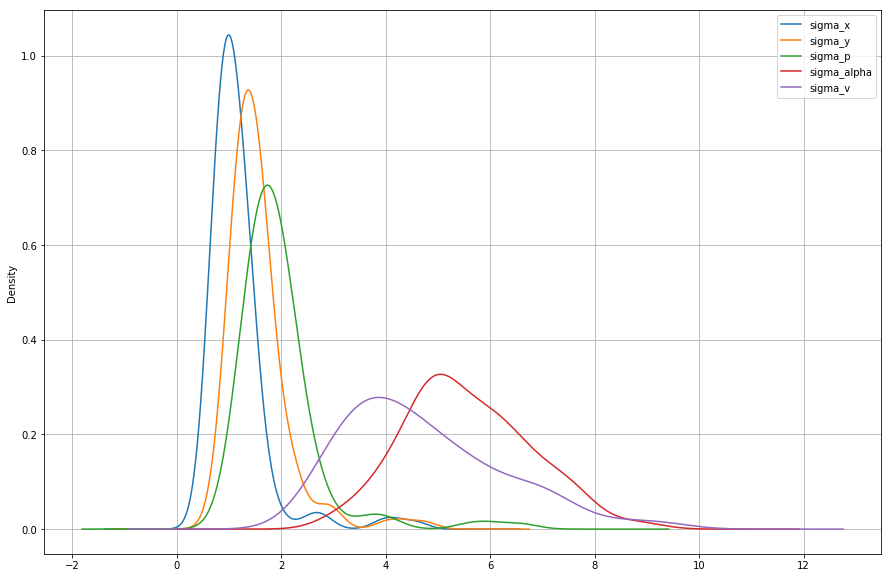

In [174]:
df_e[i:j+100].plot(y=['sigma_x','sigma_y','sigma_p','sigma_alpha','sigma_v'],grid=True,kind='density',figsize=(15,10))